# CSC 215 - MiniProject 4
## Khoi Hoang

In [1]:
import os
import csv
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import sklearn.feature_extraction.text as sk_text
import scipy as sp
import math
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.pyplot import figure, show
from IPython.display import Markdown, display
from sklearn import metrics

%matplotlib inline

In [2]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)    

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()    
    
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    
# Print markdown style
def printmd(string):
    display(Markdown(string))
    
def to_sequences(seq_size, data, target):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data.iloc[(i+SEQUENCE_SIZE)]
        window = window.values.tolist()
        x.append(window)
        y.append(after_window[target])
        
    return np.array(x),np.array(y)

# Data Preprocessing

In [3]:
df = pd.read_csv('CSC215_Project4_Stock_Price.csv')

In [4]:
df.drop(columns=['Adj_Close','Date'], inplace=True)
df.head()

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600


In [5]:
#df['Open'] = zscore(df['Open'])
#df['High'] = zscore(df['High'])
#df['Low'] = zscore(df['Low'])
#df['Volume'] = zscore(df['Volume'])
encode_numeric_zscore(df, 'Open')
encode_numeric_zscore(df, 'High')
encode_numeric_zscore(df, 'Low')
encode_numeric_zscore(df, 'Volume')
print(df.shape)
df.tail()

(4392, 5)


,Open,High,Low,Close,Volume
4387,2.782154,2.754177,2.787407,113.309998,-0.575988
4388,2.739700,2.735310,2.732368,111.870003,-0.048610
4389,2.723320,2.700885,2.701641,112.230003,0.155816
4390,2.737694,2.714457,2.760732,112.339996,-0.390000
4391,2.732346,2.777017,2.761069,113.190002,-0.167936


In [6]:
x, y = to_xy(df, 'Close')

In [7]:
x_train = x[0:int(0.7*len(x))]
x_test = x[int(0.7*len(x)):]
y_train = y[0:int(0.7*len(y))]
y_test = y[int(0.7*len(y)):]

In [8]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=43)

In [9]:
x_test.shape

(1318, 4)

# Fully Connected Neural Network

In [10]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import LSTM, Embedding, Bidirectional, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from tensorflow import keras

Using TensorFlow backend.


In [58]:
checkpointer = ModelCheckpoint(filepath="save/nn.hdf5", verbose=1, save_best_only=True) # save best model
activation_func = ['relu', 'tanh']
optimizer_func = ['adam', 'sgd']
for i in range(2):
    for j in range(2):
        #printmd("\n**Iteration**: {}".format(i))
        printmd("**Activation** = {}  **Optimizer** = {} ".format(activation_func[i], optimizer_func[j]))
        model = Sequential()

        model.add(Dense(128, input_dim=x_train.shape[1], activation=activation_func[i])) # Hidden 1     #  why input_dim=x.shape[1]?  
        model.add(Dropout(0.25))
        model.add(Dense(64, activation=activation_func[i])) # Hidden 2
        model.add(Dropout(0.25))
        model.add(Dense(32, activation=activation_func[i])) 
        model.add(Dense(1)) # Output

        model.compile(loss='mean_squared_error', optimizer=optimizer_func[j], metrics=['accuracy'])

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

        model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=500, batch_size=32, shuffle=True)

print('Training finished...Loading the best model')  
print()
model.load_weights("save/nn.hdf5") # load weights from best model    

**Activation** = relu  **Optimizer** = adam 

Train on 3074 samples, validate on 1318 samples
Epoch 1/500
 - 1s - loss: 222.4060 - acc: 3.2531e-04 - val_loss: 173.7106 - val_acc: 7.5873e-04

Epoch 00001: val_loss improved from inf to 173.71063, saving model to save/nn.hdf5
Epoch 2/500
 - 0s - loss: 34.9920 - acc: 6.5062e-04 - val_loss: 582.0878 - val_acc: 0.0000e+00

Epoch 00002: val_loss did not improve from 173.71063
Epoch 3/500
 - 0s - loss: 14.7638 - acc: 0.0016 - val_loss: 132.5841 - val_acc: 7.5873e-04

Epoch 00003: val_loss improved from 173.71063 to 132.58411, saving model to save/nn.hdf5
Epoch 4/500
 - 0s - loss: 7.1028 - acc: 0.0016 - val_loss: 52.3247 - val_acc: 7.5873e-04

Epoch 00004: val_loss improved from 132.58411 to 52.32468, saving model to save/nn.hdf5
Epoch 5/500
 - 0s - loss: 5.0101 - acc: 0.0016 - val_loss: 4.4458 - val_acc: 0.0038

Epoch 00005: val_loss improved from 52.32468 to 4.44577, saving model to save/nn.hdf5
Epoch 6/500
 - 0s - loss: 4.8782 - acc: 0.0033 - val_loss: 5.0943 - val_acc: 0.0023

Epoch 00

**Activation** = relu  **Optimizer** = sgd 

Train on 3074 samples, validate on 1318 samples
Epoch 1/500
 - 1s - loss: 67.0478 - acc: 9.7593e-04 - val_loss: 119.7923 - val_acc: 7.5873e-04

Epoch 00001: val_loss did not improve from 0.71870
Epoch 2/500
 - 0s - loss: 10.6425 - acc: 9.7593e-04 - val_loss: 337.1246 - val_acc: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.71870
Epoch 3/500
 - 0s - loss: 10.0422 - acc: 0.0013 - val_loss: 689.2208 - val_acc: 0.0000e+00

Epoch 00003: val_loss did not improve from 0.71870
Epoch 4/500
 - 0s - loss: 16.2396 - acc: 0.0013 - val_loss: 166.3933 - val_acc: 7.5873e-04

Epoch 00004: val_loss did not improve from 0.71870
Epoch 5/500
 - 0s - loss: 18.8708 - acc: 9.7593e-04 - val_loss: 1876.2572 - val_acc: 0.0000e+00

Epoch 00005: val_loss did not improve from 0.71870
Epoch 6/500
 - 0s - loss: 34.8814 - acc: 0.0013 - val_loss: 301.9319 - val_acc: 7.5873e-04

Epoch 00006: val_loss did not improve from 0.71870
Epoch 00006: early stopping


**Activation** = tanh  **Optimizer** = adam 

Train on 3074 samples, validate on 1318 samples
Epoch 1/500
 - 1s - loss: 229.0278 - acc: 3.2531e-04 - val_loss: 3953.6373 - val_acc: 0.0000e+00

Epoch 00001: val_loss did not improve from 0.71870
Epoch 2/500
 - 0s - loss: 114.8703 - acc: 9.7593e-04 - val_loss: 3573.4302 - val_acc: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.71870
Epoch 3/500
 - 0s - loss: 87.2133 - acc: 0.0013 - val_loss: 3301.1509 - val_acc: 0.0000e+00

Epoch 00003: val_loss did not improve from 0.71870
Epoch 4/500
 - 0s - loss: 66.7606 - acc: 0.0016 - val_loss: 3050.3392 - val_acc: 0.0000e+00

Epoch 00004: val_loss did not improve from 0.71870
Epoch 5/500
 - 0s - loss: 51.4958 - acc: 0.0033 - val_loss: 2841.3232 - val_acc: 0.0000e+00

Epoch 00005: val_loss did not improve from 0.71870
Epoch 6/500
 - 0s - loss: 40.0951 - acc: 0.0029 - val_loss: 2662.0832 - val_acc: 0.0000e+00

Epoch 00006: val_loss did not improve from 0.71870
Epoch 7/500
 - 0s - loss: 31.2133 - acc: 0.0023 - val_loss: 2505.3854 - val_ac

**Activation** = tanh  **Optimizer** = sgd 

Train on 3074 samples, validate on 1318 samples
Epoch 1/500
 - 1s - loss: 35.0764 - acc: 0.0013 - val_loss: 1719.7845 - val_acc: 0.0000e+00

Epoch 00001: val_loss did not improve from 0.71870
Epoch 2/500
 - 0s - loss: 6.7532 - acc: 0.0013 - val_loss: 1388.1861 - val_acc: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.71870
Epoch 3/500
 - 0s - loss: 4.3619 - acc: 0.0020 - val_loss: 2292.8324 - val_acc: 7.5873e-04

Epoch 00003: val_loss did not improve from 0.71870
Epoch 4/500
 - 0s - loss: 3.3036 - acc: 0.0026 - val_loss: 1503.2861 - val_acc: 7.5873e-04

Epoch 00004: val_loss did not improve from 0.71870
Epoch 5/500
 - 0s - loss: 2.8502 - acc: 0.0023 - val_loss: 1463.3392 - val_acc: 7.5873e-04

Epoch 00005: val_loss did not improve from 0.71870
Epoch 6/500
 - 0s - loss: 2.5531 - acc: 0.0029 - val_loss: 1551.0686 - val_acc: 0.0000e+00

Epoch 00006: val_loss did not improve from 0.71870
Epoch 7/500
 - 0s - loss: 2.2683 - acc: 0.0049 - val_loss: 1551.0682 - val_acc: 7.5873e-04

E

In [62]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 128)               640       
_________________________________________________________________
dropout_61 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_122 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_62 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_123 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_124 (Dense)            (None, 1)                 33        
Total params: 11,009
Trainable params: 11,009
Non-trainable params: 0
_________________________________________________________________


In [63]:
nn_pred = model.predict(x_test)

nn_rmse = np.sqrt(metrics.mean_squared_error(nn_pred, y_test))
printmd("-----------------**Fully-Connected Neural Network Report**---------------")
print("RMSE score: {}".format(nn_rmse))

-----------------**Fully-Connected Neural Network Report**---------------

RMSE score: 65.80767822265625


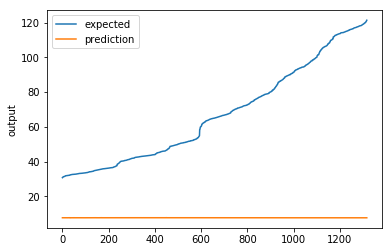

In [64]:
chart_regression(nn_pred.flatten(), y_test)

# LSTM model

In [90]:
df = pd.read_csv('CSC215_Project4_Stock_Price.csv')

In [91]:
df.drop(columns=['Adj_Close','Date'], inplace=True)
df.head()

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600


In [92]:
SEQUENCE_SIZE = 7
x, y = to_sequences(SEQUENCE_SIZE,df, 'Close')
#df_lstm = df.copy().astype('float64')
#df_lstm.head()

In [93]:
x = zscore(x)
x_train = x[0:int(0.7*len(x))]
x_test = x[int(0.7*len(x)):]
y_train = y[0:int(0.7*len(y))]
y_test = y[int(0.7*len(y)):]
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (3068, 7, 5)
Shape of x_test: (1316, 7, 5)
Shape of y_train: (3068,)
Shape of y_test: (1316,)


In [86]:
checkpointer = ModelCheckpoint(filepath="save/lstm.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    printmd("\n**Iteration**: {}".format(i))
    #print("\nIteration: {}".format(i))
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu', dropout=0.25, recurrent_dropout=0.16, return_sequences=True, input_shape=(7, 5))))
    model.add(Bidirectional(LSTM(50, activation='relu', dropout=0.25, recurrent_dropout=0.16, return_sequences=True)))
    model.add(LSTM(50, activation='relu', dropout=0.25, recurrent_dropout=0.16))
    #model.add(LSTM(50, activation='relu'))
    #model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor, checkpointer],verbose=2, epochs=1000, batch_size=64)  
    
print('Training finished...Loading the best model')  
print()
model.load_weights("save/lstm.hdf5") # load weights from best model    


**Iteration**: 0

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 18s - loss: 282.8364 - acc: 3.2595e-04 - val_loss: 1154712.5776 - val_acc: 0.0000e+00
Epoch 2/1000
 - 4s - loss: 44.5592 - acc: 0.0000e+00 - val_loss: 26213.4544 - val_acc: 7.5988e-04
Epoch 3/1000
 - 4s - loss: 23.5680 - acc: 0.0000e+00 - val_loss: 80.0340 - val_acc: 0.0015
Epoch 4/1000
 - 4s - loss: 15.3755 - acc: 3.2595e-04 - val_loss: 22.8874 - val_acc: 0.0015
Epoch 5/1000
 - 4s - loss: 12.4060 - acc: 0.0013 - val_loss: 326.7852 - val_acc: 0.0023
Epoch 6/1000
 - 4s - loss: 9.5067 - acc: 0.0026 - val_loss: 96.7833 - val_acc: 7.5988e-04
Epoch 7/1000
 - 5s - loss: 8.3107 - acc: 0.0020 - val_loss: 119.6837 - val_acc: 0.0015
Epoch 8/1000
 - 4s - loss: 7.2568 - acc: 9.7784e-04 - val_loss: 269.1581 - val_acc: 7.5988e-04
Epoch 9/1000
 - 4s - loss: 6.4267 - acc: 0.0020 - val_loss: 326.5696 - val_acc: 7.5988e-04
Epoch 00009: early stopping



**Iteration**: 1

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 19s - loss: 279.6224 - acc: 0.0000e+00 - val_loss: 1524481.8330 - val_acc: 0.0000e+00
Epoch 2/1000
 - 4s - loss: 143.9355 - acc: 6.5189e-04 - val_loss: 28140.2293 - val_acc: 0.0000e+00
Epoch 3/1000
 - 4s - loss: 34.9013 - acc: 0.0000e+00 - val_loss: 6686.5110 - val_acc: 0.0000e+00
Epoch 4/1000
 - 4s - loss: 20.7661 - acc: 0.0013 - val_loss: 6893.5461 - val_acc: 0.0000e+00
Epoch 5/1000
 - 4s - loss: 16.7666 - acc: 0.0016 - val_loss: 8394.1280 - val_acc: 0.0023
Epoch 6/1000
 - 4s - loss: 14.9277 - acc: 9.7784e-04 - val_loss: 5329.5139 - val_acc: 7.5988e-04
Epoch 7/1000
 - 4s - loss: 13.5343 - acc: 6.5189e-04 - val_loss: 3016.3389 - val_acc: 7.5988e-04
Epoch 8/1000
 - 4s - loss: 11.5935 - acc: 0.0023 - val_loss: 3695.0094 - val_acc: 0.0000e+00
Epoch 9/1000
 - 4s - loss: 9.6637 - acc: 0.0020 - val_loss: 1250.5793 - val_acc: 0.0023
Epoch 10/1000
 - 4s - loss: 9.3215 - acc: 9.7784e-04 - val_loss: 4749.5565 - val_acc: 7.5988e-04



**Iteration**: 2

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 21s - loss: 266.6368 - acc: 0.0000e+00 - val_loss: 3991759.3590 - val_acc: 7.5988e-04
Epoch 2/1000
 - 4s - loss: 53.4693 - acc: 6.5189e-04 - val_loss: 43599.3642 - val_acc: 0.0000e+00
Epoch 3/1000
 - 4s - loss: 25.2160 - acc: 9.7784e-04 - val_loss: 67417.1396 - val_acc: 0.0000e+00
Epoch 4/1000
 - 4s - loss: 16.9085 - acc: 9.7784e-04 - val_loss: 68190.0575 - val_acc: 7.5988e-04
Epoch 5/1000
 - 4s - loss: 12.9478 - acc: 3.2595e-04 - val_loss: 55436.9584 - val_acc: 0.0000e+00
Epoch 6/1000
 - 4s - loss: 10.0302 - acc: 0.0013 - val_loss: 44349.6000 - val_acc: 0.0000e+00
Epoch 7/1000
 - 4s - loss: 8.4900 - acc: 0.0029 - val_loss: 45070.1340 - val_acc: 0.0023
Epoch 00007: early stopping



**Iteration**: 3

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 21s - loss: 259.4204 - acc: 3.2595e-04 - val_loss: 545154.5752 - val_acc: 0.0000e+00
Epoch 2/1000
 - 4s - loss: 44.6664 - acc: 3.2595e-04 - val_loss: 13860.5253 - val_acc: 7.5988e-04
Epoch 3/1000
 - 4s - loss: 21.4758 - acc: 0.0013 - val_loss: 188.2849 - val_acc: 0.0000e+00
Epoch 4/1000
 - 4s - loss: 15.0166 - acc: 9.7784e-04 - val_loss: 103.9900 - val_acc: 7.5988e-04
Epoch 5/1000
 - 4s - loss: 11.6514 - acc: 0.0029 - val_loss: 103.4153 - val_acc: 0.0015
Epoch 6/1000
 - 4s - loss: 9.7295 - acc: 6.5189e-04 - val_loss: 146.4753 - val_acc: 7.5988e-04
Epoch 7/1000
 - 4s - loss: 8.4948 - acc: 0.0013 - val_loss: 289.1890 - val_acc: 7.5988e-04
Epoch 8/1000
 - 4s - loss: 7.2913 - acc: 0.0016 - val_loss: 274.4896 - val_acc: 7.5988e-04
Epoch 9/1000
 - 4s - loss: 6.7161 - acc: 0.0013 - val_loss: 347.9128 - val_acc: 7.5988e-04
Epoch 10/1000
 - 4s - loss: 5.9438 - acc: 0.0013 - val_loss: 315.6721 - val_acc: 0.0015
Epoch 00010: early st


**Iteration**: 4

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 23s - loss: 275.1879 - acc: 0.0000e+00 - val_loss: 2620713.3442 - val_acc: 0.0000e+00
Epoch 2/1000
 - 4s - loss: 41.4892 - acc: 6.5189e-04 - val_loss: 4968.2180 - val_acc: 0.0000e+00
Epoch 3/1000
 - 4s - loss: 22.5830 - acc: 0.0013 - val_loss: 2620.2519 - val_acc: 0.0000e+00
Epoch 4/1000
 - 4s - loss: 15.3168 - acc: 0.0000e+00 - val_loss: 459.2789 - val_acc: 0.0000e+00
Epoch 5/1000
 - 4s - loss: 11.3207 - acc: 0.0020 - val_loss: 415.9175 - val_acc: 0.0015
Epoch 6/1000
 - 4s - loss: 8.2309 - acc: 0.0020 - val_loss: 626.0689 - val_acc: 0.0015
Epoch 7/1000
 - 4s - loss: 7.7366 - acc: 0.0020 - val_loss: 2019.0904 - val_acc: 0.0015
Epoch 8/1000
 - 4s - loss: 7.2263 - acc: 0.0026 - val_loss: 1937.9788 - val_acc: 7.5988e-04
Epoch 9/1000
 - 4s - loss: 6.0021 - acc: 0.0016 - val_loss: 1278.5956 - val_acc: 0.0015
Epoch 10/1000
 - 4s - loss: 5.7604 - acc: 0.0013 - val_loss: 1768.3416 - val_acc: 0.0015
Epoch 00010: early stopping
Trai

In [87]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_27 (Bidirectio (None, 7, 100)            22400     
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 7, 100)            60400     
_________________________________________________________________
lstm_68 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 51        
Total params: 113,051
Trainable params: 113,051
Non-trainable params: 0
_________________________________________________________________


In [88]:
lstm_pred = model.predict(x_test)
lstm_rmse = np.sqrt(metrics.mean_squared_error(lstm_pred,y_test))
print("Score (RMSE): {}".format(lstm_rmse))

Score (RMSE): 4.784077073607012


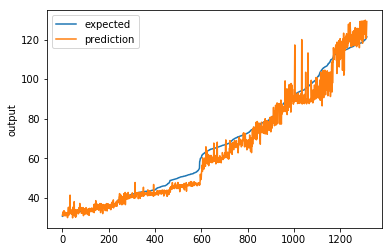

In [89]:
chart_regression(lstm_pred.flatten(), y_test)

In [94]:
checkpointer = ModelCheckpoint(filepath="save/lstm_nodropout.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    printmd("\n**Iteration**: {}".format(i))
    #print("\nIteration: {}".format(i))
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True, input_shape=(7, 5))))
    model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True)))
    model.add(LSTM(50, activation='relu'))
    #model.add(LSTM(50, activation='relu'))
    #model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor, checkpointer],verbose=2, epochs=1000, batch_size=64)  
    
print('Training finished...Loading the best model')  
print()
model.load_weights("save/lstm_nodropout.hdf5") # load weights from best model 


**Iteration**: 0

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 22s - loss: 277.7243 - acc: 0.0000e+00 - val_loss: 3600651.9857 - val_acc: 0.0000e+00
Epoch 2/1000
 - 4s - loss: 34.2333 - acc: 0.0013 - val_loss: 798174.5054 - val_acc: 0.0000e+00
Epoch 3/1000
 - 4s - loss: 8.3750 - acc: 0.0000e+00 - val_loss: 761354.1609 - val_acc: 7.5988e-04
Epoch 4/1000
 - 4s - loss: 2.1463 - acc: 0.0029 - val_loss: 448010.5624 - val_acc: 7.5988e-04
Epoch 5/1000
 - 4s - loss: 0.8296 - acc: 0.0062 - val_loss: 373680.9152 - val_acc: 0.0000e+00
Epoch 6/1000
 - 4s - loss: 0.6735 - acc: 0.0059 - val_loss: 253963.1699 - val_acc: 0.0015
Epoch 7/1000
 - 4s - loss: 0.5596 - acc: 0.0068 - val_loss: 192792.6687 - val_acc: 7.5988e-04
Epoch 8/1000
 - 4s - loss: 0.5236 - acc: 0.0072 - val_loss: 243071.5426 - val_acc: 0.0015
Epoch 9/1000
 - 4s - loss: 0.4730 - acc: 0.0075 - val_loss: 163560.0404 - val_acc: 7.5988e-04
Epoch 10/1000
 - 4s - loss: 0.4530 - acc: 0.0075 - val_loss: 187737.2074 - val_acc: 0.0000e+00
Epoch 


**Iteration**: 1

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 22s - loss: 434.5343 - acc: 3.2595e-04 - val_loss: 2447.5069 - val_acc: 0.0000e+00
Epoch 2/1000
 - 4s - loss: 205.7432 - acc: 0.0000e+00 - val_loss: 1403417.8927 - val_acc: 0.0000e+00
Epoch 3/1000
 - 4s - loss: 30.7249 - acc: 3.2595e-04 - val_loss: 34386.9686 - val_acc: 0.0000e+00
Epoch 4/1000
 - 4s - loss: 7.8099 - acc: 6.5189e-04 - val_loss: 13611.3309 - val_acc: 0.0015
Epoch 5/1000
 - 4s - loss: 1.4057 - acc: 0.0049 - val_loss: 4444.7518 - val_acc: 0.0023
Epoch 6/1000
 - 4s - loss: 0.7308 - acc: 0.0062 - val_loss: 2813.1319 - val_acc: 7.5988e-04
Epoch 00006: early stopping



**Iteration**: 2

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 23s - loss: 286.6766 - acc: 3.2595e-04 - val_loss: 816140.5368 - val_acc: 0.0000e+00
Epoch 2/1000
 - 4s - loss: 34.3805 - acc: 3.2595e-04 - val_loss: 90532.2602 - val_acc: 0.0000e+00
Epoch 3/1000
 - 4s - loss: 6.4027 - acc: 6.5189e-04 - val_loss: 60527.7366 - val_acc: 0.0030
Epoch 4/1000
 - 4s - loss: 2.0064 - acc: 0.0029 - val_loss: 38293.9405 - val_acc: 7.5988e-04
Epoch 5/1000
 - 4s - loss: 0.8939 - acc: 0.0049 - val_loss: 27891.9531 - val_acc: 0.0015
Epoch 6/1000
 - 4s - loss: 0.6531 - acc: 0.0059 - val_loss: 30662.9240 - val_acc: 7.5988e-04
Epoch 7/1000
 - 4s - loss: 0.5810 - acc: 0.0072 - val_loss: 29056.4284 - val_acc: 7.5988e-04
Epoch 8/1000
 - 4s - loss: 0.5181 - acc: 0.0072 - val_loss: 34753.4483 - val_acc: 0.0015
Epoch 9/1000
 - 4s - loss: 0.5267 - acc: 0.0078 - val_loss: 31482.0818 - val_acc: 0.0023
Epoch 10/1000
 - 4s - loss: 0.4687 - acc: 0.0068 - val_loss: 27305.8362 - val_acc: 0.0023
Epoch 11/1000
 - 4s - lo


**Iteration**: 3

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 25s - loss: 296.4802 - acc: 0.0000e+00 - val_loss: 80860.2899 - val_acc: 0.0000e+00
Epoch 2/1000
 - 4s - loss: 37.4035 - acc: 3.2595e-04 - val_loss: 88247.2942 - val_acc: 7.5988e-04
Epoch 3/1000
 - 4s - loss: 2.2087 - acc: 0.0036 - val_loss: 42516.9931 - val_acc: 0.0000e+00
Epoch 4/1000
 - 4s - loss: 0.6898 - acc: 0.0068 - val_loss: 38955.1563 - val_acc: 0.0015
Epoch 5/1000
 - 4s - loss: 0.6420 - acc: 0.0078 - val_loss: 36767.3911 - val_acc: 7.5988e-04
Epoch 6/1000
 - 4s - loss: 0.5904 - acc: 0.0062 - val_loss: 35124.0884 - val_acc: 0.0015
Epoch 7/1000
 - 4s - loss: 0.5544 - acc: 0.0078 - val_loss: 35595.8957 - val_acc: 7.5988e-04
Epoch 8/1000
 - 4s - loss: 0.5271 - acc: 0.0075 - val_loss: 27468.0432 - val_acc: 0.0023
Epoch 9/1000
 - 4s - loss: 0.5029 - acc: 0.0065 - val_loss: 27515.4946 - val_acc: 7.5988e-04
Epoch 10/1000
 - 4s - loss: 0.4748 - acc: 0.0075 - val_loss: 24772.6011 - val_acc: 7.5988e-04
Epoch 11/1000
 - 5s -


**Iteration**: 4

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 25s - loss: 276.7722 - acc: 0.0000e+00 - val_loss: 917006.2403 - val_acc: 0.0000e+00
Epoch 2/1000
 - 4s - loss: 41.0796 - acc: 0.0000e+00 - val_loss: 86591.7424 - val_acc: 0.0000e+00
Epoch 3/1000
 - 4s - loss: 7.0756 - acc: 9.7784e-04 - val_loss: 56590.3985 - val_acc: 0.0000e+00
Epoch 4/1000
 - 4s - loss: 2.1865 - acc: 0.0033 - val_loss: 29957.5082 - val_acc: 7.5988e-04
Epoch 5/1000
 - 4s - loss: 0.8543 - acc: 0.0059 - val_loss: 29475.6666 - val_acc: 7.5988e-04
Epoch 6/1000
 - 4s - loss: 0.6793 - acc: 0.0046 - val_loss: 23307.4498 - val_acc: 0.0000e+00
Epoch 7/1000
 - 4s - loss: 0.5601 - acc: 0.0068 - val_loss: 19715.6332 - val_acc: 7.5988e-04
Epoch 8/1000
 - 4s - loss: 0.4841 - acc: 0.0065 - val_loss: 17080.7229 - val_acc: 0.0015
Epoch 9/1000
 - 4s - loss: 0.4841 - acc: 0.0068 - val_loss: 15778.9749 - val_acc: 7.5988e-04
Epoch 10/1000
 - 4s - loss: 0.5038 - acc: 0.0078 - val_loss: 12377.2393 - val_acc: 7.5988e-04
Epoch 11

In [96]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_37 (Bidirectio (None, 7, 100)            22400     
_________________________________________________________________
bidirectional_38 (Bidirectio (None, 7, 100)            60400     
_________________________________________________________________
lstm_83 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 51        
Total params: 113,051
Trainable params: 113,051
Non-trainable params: 0
_________________________________________________________________


In [97]:
lstm_nodropout_pred = model.predict(x_test)
lstm_nodropout_rmse = np.sqrt(metrics.mean_squared_error(lstm_nodropout_pred,y_test))
print("Score (RMSE): {}".format(lstm_nodropout_rmse))

Score (RMSE): 8.14249061375073


In [102]:
lstm_nodropout_pred.flatten().shape

(1316,)

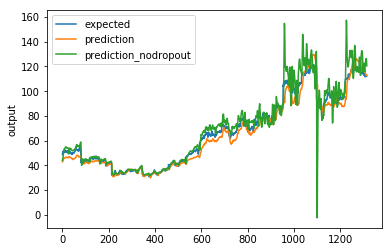

In [103]:
t = pd.DataFrame({'pred' : lstm_pred.flatten(), 'pred_nodropout': lstm_nodropout_pred.flatten(), 'y' : y_test.flatten()})   
a = plt.plot(t['y'].tolist(),label='expected')
b = plt.plot(t['pred'].tolist(),label='prediction')
c = plt.plot(t['pred_nodropout'].tolist(),label='prediction_nodropout')
plt.ylabel('output')
plt.legend()
plt.show()    

# CNN model

In [55]:
df = pd.read_csv('CSC215_Project4_Stock_Price.csv')

In [56]:
df.drop(columns=['Adj_Close','Date'], inplace=True)
df.head()

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600


In [57]:
SEQUENCE_SIZE = 7
x, y = to_sequences(SEQUENCE_SIZE,df, 'Close')
x = zscore(x)

print("Shape of x: {}".format(x.shape))
print("Shape of y: {}".format(y.shape))

Shape of x: (4384, 7, 5)
Shape of y: (4384,)


In [58]:
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
print(x.shape)

(4384, 7, 5, 1)


In [59]:
x_train = x[0:int(0.7*len(x))]
x_test = x[int(0.7*len(x)):]
y_train = y[0:int(0.7*len(y))]
y_test = y[int(0.7*len(y)):]
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (3068, 7, 5, 1)
Shape of x_test: (1316, 7, 5, 1)
Shape of y_train: (3068,)
Shape of y_test: (1316,)


In [60]:
checkpointer = ModelCheckpoint(filepath="save/cnn.hdf5", verbose=0, save_best_only=True) # save best model
input_shape = (7, 5, 1)
for i in range(5):
    printmd("\n**Iteration**: {}".format(i))
    #print("Iteration: {}".format(i))
    #Build network
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(1, 2), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=input_shape))
    model.add(Conv2D(64, (1, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=None))
    model.add(Dropout(0.25)) 
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=1000, batch_size=64, shuffle=True)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    
    
print('Training finished...Loading the best model')  
print()
model.load_weights('save/cnn.hdf5') # load weights from best model


Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
 - 2s - loss: 202.9082 - acc: 0.0000e+00 - val_loss: 3706.3130 - val_acc: 0.0000e+00
Epoch 2/1000
 - 0s - loss: 30.4538 - acc: 3.2595e-04 - val_loss: 1488.9141 - val_acc: 0.0015
Epoch 3/1000
 - 0s - loss: 10.8094 - acc: 0.0013 - val_loss: 120.7211 - val_acc: 0.0023
Epoch 4/1000
 - 0s - loss: 6.6618 - acc: 0.0033 - val_loss: 51.8217 - val_acc: 0.0000e+00
Epoch 5/1000
 - 0s - loss: 6.1721 - acc: 0.0020 - val_loss: 113.3745 - val_acc: 7.5988e-04
Epoch 6/1000
 - 0s - loss: 5.8043 - acc: 0.0023 - val_loss: 62.5728 - val_acc: 0.0000e+00
Epoch 7/1000
 - 0s - loss: 6.3758 - acc: 0.0036 - val_loss: 39.2792 - val_acc: 0.0038
Epoch 8/1000
 - 0s - loss: 5.8083 - acc: 0.0033 - val_loss: 78.1931 - val_acc: 7.5988e-04
Epoch 9/1000
 - 0s - loss: 5.5844 - acc: 0.0033 - val_loss: 49.3706 - val_acc: 7.5988e-04
Epoch 10/1000
 - 0s - loss: 5.0542 - acc: 0.0029 - val_loss: 77.9770 - val_acc: 7.5988e-04
Epoch 11/1000
 - 0s - loss: 5.8167 - acc: 0.0

In [61]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 7, 4, 32)          96        
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 7, 3, 64)          4160      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 1, 64)          0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 7, 1, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 448)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 128)               57472     
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
__________

In [62]:
cnn_pred = model.predict(x_test)
cnn_rmse = np.sqrt(metrics.mean_squared_error(cnn_pred,y_test))
print("Score (RMSE): {}".format(cnn_rmse))

Score (RMSE): 2.6811384030232093


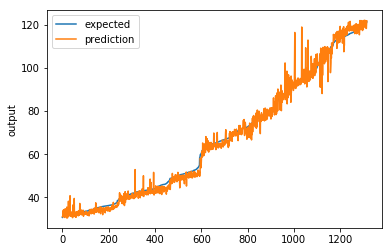

In [63]:
chart_regression(cnn_pred.flatten(), y_test)